# Demo for dynamic texture synthesis via auto-regresion of the frame sequence

In [1]:
%load_ext autoreload
import cv2

import os
import sys
import glob
import shutil
import re
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from IPython.display import clear_output
from IPython.core.debugger import set_trace
import torch
import torchvision
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.animation as anim
from torchvision.transforms import Resize, ToTensor, Compose

SIZE = 64
%autoreload 2

# Load data

In [2]:
# data_root = './data/dynamic_textures_selected'

# video_root = os.path.join(data_root,'videos')
# frames_root = os.path.join(data_root,'frames')
# video_names = os.listdir(video_root)

# for video_name in tqdm_notebook(video_names):
#     video_label = video_name.split('.')[0]
#     video_path = os.path.join(video_root, video_name)
#     vidcap = cv2.VideoCapture(video_path)
#     success, image = vidcap.read()

#     frames_folder = os.path.join(frames_root, video_label)
#     os.makedirs(frames_folder, exist_ok=True)
    
#     if not success:
#         print(f'{video_name} has not been readed! Skipping')
#         continue
    
#     count = 0
#     while success:
#         cv2.imwrite(os.path.join(frames_folder, "{:05d}.jpg".format(count)), image)     # save frame as JPEG file      
#         success, image = vidcap.read()
#         count += 1

/tmp/ipykernel_1465381/1171577675.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for video_name in tqdm_notebook(video_names):


  0%|          | 0/4 [00:00<?, ?it/s]

# Model

In [4]:
class VideoDataset(Dataset):
  
    def __init__(self, root_dir, seq_len=4, transform=None):
        
        '''
        root_dir - contrains folders with frames for each video
        '''
        
        self.root_dir = root_dir
        self.video_names = os.listdir(root_dir)
        self.transform = transform
        self.seq_len = seq_len
        self.indx_texture_sequence = [] # total list of samples of `seq_len` 
        
        for video_name in video_names:
            video_dir = os.path.join(root_dir, video_name)
            # number of `seq_len` samples we can take from this dir
            n_framesets = len(os.listdir(video_dir)) - (seq_len) + 1
            if n_framesets <= 0:
                continue
            for i in range(n_framesets):
                # i - number of the sequence from the start
                # video_dir - fold of the seq
                self.indx_texture_sequence.append([video_dir, i])

    def __getitem__(self, idx):
        fold, i = self.indx_texture_sequence[idx]
        return get_seq(fold, self.seq_len, i)

    def __len__(self):
        return len(self.indx_texture_sequence)
    
    
def get_seq(fold, seq_len, i):
    
    '''
    fold - folder of the sequence
    seq_len - length of the sequence
    i - starting frame
    '''

    transforms = Compose([Resize((SIZE,SIZE)), ToTensor()])
    names = sorted(os.listdir(fold))

    seq = []

    for name in names:
        image_path = os.path.join(fold, name)
        img = Image.open(image_path)
        img_trasformed = transforms(img)
        seq += [img_trasformed.unsqueeze(1)]

    seq = torch.cat(seq, 1)

    return seq

In [5]:
# def deprocess(img_tensor):
#     img = img_tensor[0].detach().cpu().numpy().transpose(1,2,0)
#     img= np.clip(img, 0, 1)
#     img = img.astype('float')

#     return  img  
  
# def extend_sequence(seq, new_img):
#     dt = seq.shape[2]
#     new_seq = torch.cat([seq[:,:,list(range(dt - 1)),...], new_img.unsqueeze(2)],2)
#     return new_seq


# class PerceptualLoss(torch.nn.Module):

#     def __init__(self, vgg):
#         super(PerceptualLoss, self).__init__()
#         self.vgg = vgg
#         self.vgg_layers = vgg.features
#         self.layer_name_mapping = {
#             '3': "relu1_2",
#             '8': "relu2_2",
#             '15': "relu3_3",
#             '22': "relu4_3"
#         }
   
                
#     def forward(self, x1, x2):
#         loss = 0
#         x = torch.cat((x1,x2),0)
#         for name, module in self.vgg_layers._modules.items():
#             x1 = module(x1)
#             x2 = module(x2)
#             if name in self.layer_name_mapping:
#                 BS,C,H,W = x1.shape
#                 loss += ((x1 - x2).pow(2) / (C*H*W)).sum()
#         return loss
        
        
        
# def calculate_seq_loss(generator,
#                         seq_batch,
#                         loss_batch, 
#                         use_mse = True,
#                         use_discriminator = False,
#                         use_perceptual = False,
#                         discriminator = None,
#                         which_loss = 'gen_loss',
#                         eps = 1e-1,
#                         weight = 1.):

    
#     loss = 0.
#     batch_size = loss_batch.shape[0]
#     loss_len = loss_batch.shape[2]
    
#     if use_discriminator or use_perceptual:
#         predictions = []
    
#     for i in range(loss_len):
        
#         pred = generator(seq_batch)
#         if use_mse:
#             loss += torch.norm(pred - loss_batch[:,:,i,...], 2) / batch_size
            
#         if use_discriminator or use_perceptual:
#             predictions += [pred.unsqueeze(1)]
        
#         seq_batch = extend_sequence(seq_batch, pred)
    
#     predictions = torch.cat(predictions, 1)
    
#     if use_discriminator:
#         discr_pred_true = discriminator(loss_batch + torch.zeros_like(loss_batch).data.normal_(std = 0.05)).clamp(eps, 1.-eps)
#         discr_pred_fake = discriminator(predictions +  torch.zeros_like(predictions).data.normal_(std = 0.05)).clamp(eps, 1.-eps)
        
#         if which_loss == 'gen_loss':
#             return - discr_pred_fake.log().mean(0) + weight*loss, (predictions if use_perceptual else None)
          
#         elif which_loss == 'discr_loss':
#             return - (torch.log(1.-discr_pred_fake).mean(0) + discr_pred_true.log().mean(0))
    
#     elif use_mse:
#         return loss, None
      
#     elif use_perceptual:
#         return None, predictions
      
#     else:
#         return None, None
    

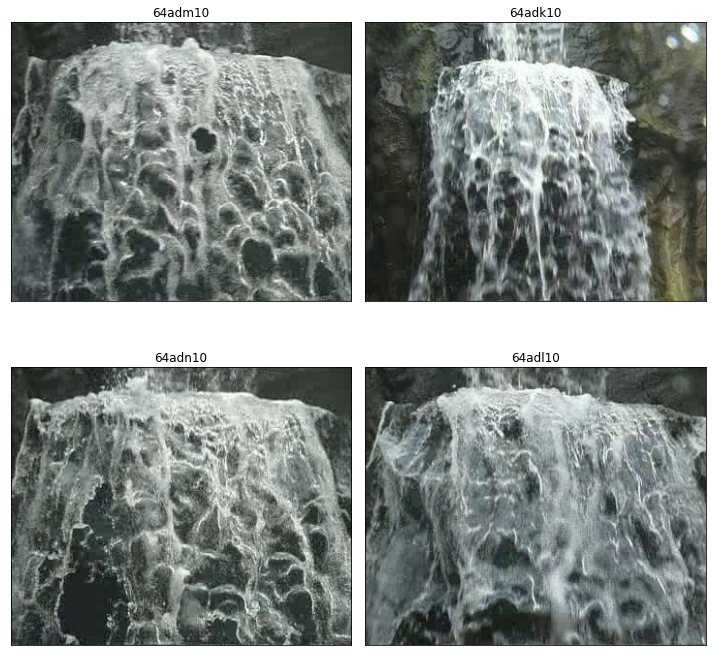

In [6]:
video_names = os.listdir(frames_root)
n_videos = len(video_names)
n_vis = np.ceil(np.sqrt(n_videos)).astype(int) 

fig, axes = plt.subplots(ncols=n_vis, 
                         nrows=n_vis, 
                         sharex=True, 
                         sharey=True,
                         figsize=(10,10))

for i, video_name in enumerate(video_names):
    
    ax = axes.flatten()[i]
    frames_fold = os.path.join(frames_root, video_name)
    
    frame_path = np.random.choice(glob.glob(os.path.join(frames_fold, '*')), size=1)[0]
    ax.imshow(plt.imread(frame_path))
    ax.set_title(video_name)
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.tight_layout()    
plt.show()


# Model

In [9]:
import yaml
from easydict import EasyDict as edict

config_path = './configs/v2v.yaml'

with open(config_path) as fin:
    config = edict(yaml.safe_load(fin))

In [14]:
from models.v2v import V2VModel
device = 'cuda:0'

model = V2VModel(config.model).to(device)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/ibulygin/miniconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_1465381/1976948642.py", line 4, in <cell line: 4>
    model = V2VModel(config.model).to(device)
  File "/nfs/tom/ibulygin/Dynamic-Textures-Autoregression/models/v2v.py", line 247, in __init__
    self.encoder_decoder = EncoderDecorder(config)
  File "/nfs/tom/ibulygin/Dynamic-Textures-Autoregression/models/v2v.py", line 152, in __init__
    if downsampling_config[N_blocks-i-1]['skip_connection']:
KeyError: 'skip_connection'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/ibulygin/miniconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 1993, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "/home/ibulygin/miniconda3/lib/python3.9/site-packag

In [8]:
X = torch.randn(10,3,64,64,64)

# Train

In [0]:
dt = 3
dl = 5

use_perceptual = False
use_discriminator = True
use_mse = False

if use_perceptual:
    vgg = torchvision.models.vgg16(pretrained=True).cuda()
    perceptual_loss = PerceptualLoss(vgg)   
    perceptual_losses = []

losses = []

if use_discriminator:
    discriminator = Discriminator(n_channels = dl*3)
    discriminator = discriminator.cuda()
    discr_losses = []
    optimizer_discr = torch.optim.Adam(discriminator.parameters(),lr=1e-4)
    
    if use_mse:
        weight = 1.
    else:
        weight = 0.
    
else:
    discriminator = None
    weight = 0.    
    

model = UNet(n_channels = dt*3, n_classes = 3)
model = model.cuda()

optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-4,
                             betas = (0.85, 0.999))



In [0]:
dyntex_data = DynTexDataset(root_fold, textures, dt, dl)
epoch = 1
epochs = 100
print_freq = 1 #epochs // 10
save_freq = 10 #50
batch_size = 40

dataloader = DataLoader(dyntex_data,
                        batch_size=batch_size,
                        shuffle=True,
                        num_workers=5) 

In [13]:
checkpoint = torch.load('./UNet_dl5_dt3_discr_v2_percept_training_state_ep90_ntext14_bs40.pt')
model.load_state_dict(checkpoint['model_state_dict'])


IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [0]:
update_discr_freq = 1

for epoch in tqdm_notebook(range(epoch,epochs + 1)):
  
    model.train()
    
    for seq_batch, loss_batch in tqdm_notebook(dataloader):
        
        seq_batch = seq_batch.cuda()
        loss_batch = loss_batch.cuda()
        
        ###################
        # MODEL TRAINING #
        ##################
        optimizer.zero_grad()
        
        if use_discriminator:
            for param in discriminator.parameters():
                param.requires_grad = False
            for param in model.parameters():
                param.requires_grad = True    
        
        loss, preds = calculate_n_iter_loss(model,
                                            seq_batch,
                                            loss_batch, 
                                            use_mse,
                                            use_discriminator,
                                            use_perceptual,
                                            discriminator = discriminator,
                                            which_loss = 'gen_loss',
                                            weight = weight)
        
        losses += [loss.detach().item()]

        if use_perceptual:
            pl = perceptual_loss(preds.transpose(1,2).contiguous().view(-1, 3, SIZE, SIZE),
                                          loss_batch.transpose(1,2).contiguous().view(-1, 3, SIZE, SIZE))
            
            loss = loss + pl
            perceptual_losses.append(pl.detach().item())
        
        loss.backward()
        optimizer.step()
        
        ##########################
        # DISCRIMINATOR TRAINING #
        ##########################
        if use_discriminator and epoch%update_discr_freq == 0:
            for param in discriminator.parameters():
                param.requires_grad = True
            for param in model.parameters():
                param.requires_grad = False 
          
            optimizer_discr.zero_grad()
            loss = calculate_n_iter_loss(model,
                                          seq_batch,
                                          loss_batch, 
                                          use_mse,
                                          use_discriminator,
                                          use_perceptual,
                                          discriminator = discriminator,
                                          which_loss = 'discr_loss',
                                          weight = weight)
            loss.backward()
            discr_losses += [loss.detach().cpu().numpy()]
            optimizer_discr.step()
  
    ###########
    # SHOWING #
    ###########
    if epoch%print_freq == 0:
        model.eval()
        plt.figure()
        plt.imshow(deprocess(model(seq_batch)))
        plt.title('epoch {}'.format(epoch))
        plt.grid(False)  
        plt.show()
        
        fig, (ax1, ax2, ax3) = plt.subplots(ncols = 3, nrows =1)
        ax1.plot(range(len(losses)), losses)
        ax1.set_title('Generator loss')
        if use_discriminator:
            ax2.plot(range(len(discr_losses)), discr_losses, 'r')
            ax2.set_title('Discriminator loss')
        if use_perceptual:
            ax3.plot(range(len(perceptual_losses)), perceptual_losses, 'g')
            ax3.set_title('Perceptual loss')
            plt.show()
    
    ##########
    # SAVING #
    ##########
    if epoch%save_freq == 0:
        print ('Saving...')
        model_type = '{0}_dl{1}_dt{2}{3}{4}{5}{6}'.format(model.__class__.__name__, #0
                                                       dl, #1
                                                       dt, #2
                                                       '_mse' if use_mse else '', #3
                                                       '_discr_v2' if use_discriminator else '', #4
                                                       '_weight{}'.format(weight) if (use_mse and use_discriminator) else '', #5
                                                       '_percept' if use_perceptual else '') #6
    
    
    
    checkpoint_name = f'./checkpoints/{experiment_name}/ep_{epoch}'
    
    state = {'model_state_dict': model.state_dict(),
             'optimizer_state_dict': optimizer.state_dict(),
             'loss_history': losses}
        
        if discriminator is not None:
            state['discriminator_state_dict'] = discriminator.state_dict()
            state['discr_losses'] = discr_losses
            state['discr_optimizer_state_dict'] = discr_optimizer.state_dict()
        if perceptual_losses is not None:
            state['perceptual_losses'] = perceptual_losses
            
        torch.save(state, PATH)




## Generation

In [0]:
root_fold = './data/dynamic_textures/'
texture_type = 'calm_water_14'

texture_fold = os.path.join(root_fold, texture_type)

def generate(model, root_fold,  texture_type, dt = 3, seq_len = 30, one_by_one = True):
  
    fold = os.path.join(root_fold, texture_type)
    N = len(os.listdir(fold))
    model.eval()
    
    if not one_by_one:
        assert(seq_len < N)
    
    generate_seq_len = seq_len
    
    starting_seq, _ = get_seq(fold, dt, 1, 0)
    current_seq = starting_seq.unsqueeze(0).cuda()

    generated_imgs = []
    for i in tqdm_notebook(range(generate_seq_len)):
        
        if i >= seq_len:
            break
        
        if not one_by_one:
            if i > N - dt - 1:
                break
              
            current_seq, _ = get_seq(fold, dt, 1, i)
            current_seq = current_seq.unsqueeze(0).cuda()
        
        new_img = model(current_seq)
        generated_imgs += [deprocess(new_img.detach())]  
        
        if one_by_one:
            current_seq = torch.cat([current_seq[:,:,list(range(dt - 1)),...],
                                      new_img.unsqueeze(2)],
                                      2).cuda()
  
    return generated_imgs
        
GEN_SEQ_LEN = 50
generated_imgs = generate(model, root_fold,  texture_type, dt = dt, seq_len = GEN_SEQ_LEN, one_by_one = True)

In [0]:
def comparison(generated_seq, texture_fold, n_plot_pairs = 3, dt = 3):
    
    diffs1 = []
    diffs2 = []
    
    fig, axes = plt.subplots(ncols = 2, nrows = n_plot_pairs, sharex=True, sharey=True, figsize = (10,10))
    
    curr_gen = generated_seq[0]
    for i, gen_img in enumerate(generated_seq):
      
        _, img = get_seq(texture_fold, dt, 1, i)
        img = deprocess(img.squeeze().unsqueeze(0))
        
        diff1 = np.linalg.norm(img - gen_img)
        diffs1 += [diff1]
        diff2 = np.linalg.norm(curr_gen - gen_img)
        diffs2 += [diff2]
        
        curr_gen = gen_img
        
        if i < n_plot_pairs: 
            axes[i][0].imshow(img)
            axes[i][0].grid(False)
            axes[i][0].set_title('original, step: {}'.format(i))

            axes[i][1].imshow(gen_img)
            axes[i][1].grid(False)
            axes[i][1].set_title('generated, step: {}'.format(i))

  #     fig.savefig('./comparison.jpg')
  #     files.download('./comparison.jpg')
    plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.0, hspace=0.2)
  #     plt.tight_layout()
    plt.show()
    
    return diffs1, diffs2[1:]
  
dist1, dist2 = comparison(generated_imgs, texture_fold, dt = dt)
rng = range(len(generated_imgs))
plt.figure()
plt.plot(rng, dist1)
plt.xlabel('frame number')
plt.ylabel('diff with original frame')
plt.figure()
plt.plot(dist2)
plt.show()

In [0]:
l6t3_dist1, l6t3_dist2 = dist1, dist2

In [0]:
plt.plot(l4t3_dist2, label = '4xloss, dt = 3')
plt.plot(l5t3_dist2, label = '5xloss, dt = 3')
plt.plot(l6t3_dist2, label = '6xloss, dt = 3')
plt.title('frame x_i - frame x_(i-1)')
plt.xlabel('# frame')
plt.legend()

In [0]:
plt.plot(l4t3_dist1, label = '4xloss, dt = 3')
plt.plot(l5t3_dist1, label = '5xloss, dt = 3')
plt.plot(l6t3_dist1, label = '6xloss, dt = 3')
plt.title('orig frame_i -  generated frame x_i')
plt.xlabel('# frame')
plt.legend()

## Saving

In [0]:
fold_save = './{0}_gen_unet_dt{1}_dl{2}_{3}/'.format(texture_type, dt, dl, GEN_SEQ_LEN)

def save(generated_imgs, fold_save, download = True):

    if save:
        if not os.path.isdir(fold_save):
            os.mkdir(fold_save)
        else:
            shutil.rmtree(fold_save)
            os.mkdir(fold_save)
  
    for i,img in enumerate(generated_imgs):
        
        image_name = os.path.join(fold_save, '{}.jpg'.format(i))
        plt.figure()
        plt.imshow(img)
        plt.grid(False)
        plt.title('step: {}'.format(i))
        plt.savefig(image_name)
        
        if download:
            files.download(image_name)   
            
save(generated_imgs, fold_save)            